In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries, data, and functions

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import mpl_toolkits.mplot3d as plt3d

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Reshape, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, UpSampling1D, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [ ]:
def loss_function(y_true, y_pred):

  bs = len(y_true)
  y_true, y_pred = tf.reshape(y_true, (bs,3,3)), tf.reshape(y_pred,(bs,3,3)) 

  perm_rows = tf.linalg.LinearOperatorPermutation([1,2,0])
  true_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_true, tf.matmul(perm_rows,y_true) ), axis=-1, keepdims=True))
  pred_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_pred, tf.matmul(perm_rows,y_pred) ), axis=-1, keepdims=True))

  return tf.reduce_sum( tf.abs( tf.math.subtract(true_dist, pred_dist) ) , axis = 1)  

In [ ]:
#Function which plots the 3D traingle
minmax = (-1,1)

def Plot_2(v1, v2, v3, vv1, vv2, vv3):
  fig = plt.figure()
  fig.set_size_inches(5,5)
  ax = fig.add_subplot(111, projection='3d')
  
  X = np.array([v1,v2,v3])
  Y = np.array([vv1,vv2,vv3])
  
  l0x, ll0x = np.linspace(v1[0], v2[0], 50), np.linspace(vv1[0], vv2[0], 50)
  l1x, ll1x = np.linspace(v2[0], v3[0], 50), np.linspace(vv2[0], vv3[0], 50)
  l2x, ll2x = np.linspace(v3[0], v1[0], 50), np.linspace(vv3[0], vv1[0], 50)
  l0y, ll0y = np.linspace(v1[1], v2[1], 50), np.linspace(vv1[1], vv2[1], 50)
  l1y, ll1y = np.linspace(v2[1], v3[1], 50), np.linspace(vv2[1], vv3[1], 50)
  l2y, ll2y = np.linspace(v3[1], v1[1], 50), np.linspace(vv3[1], vv1[1], 50)
  l0z, ll0z = np.linspace(v1[2], v2[2], 50), np.linspace(vv1[2], vv2[2], 50)
  l1z, ll1z = np.linspace(v2[2], v3[2], 50), np.linspace(vv2[2], vv3[2], 50)
  l2z, ll2z = np.linspace(v3[2], v1[2], 50), np.linspace(vv3[2], vv1[2], 50)

  #Drawing lines
  ax.scatter(l0x, l0y, l0z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll0x, ll0y, ll0z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l1x, l1y, l1z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll1x, ll1y, ll1z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l2x, l2y, l2z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll2x, ll2y, ll2z, color='black', marker='s', s = 1, alpha = 0.1)


  #plot the nodes
  for x, y, z in X:
    ax.scatter(x, y, z, color='red', marker='o', s=30)
  for x, y, z in Y:
    ax.scatter(x, y, z, color='black', marker='o', s=30)

  ax.set_xlim(minmax)
  ax.set_ylim(minmax) 
  ax.set_zlim(minmax) 

In [ ]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return np.array([np.linalg.norm(vx-vy), 
                   np.linalg.norm(vy-vz), 
                   np.linalg.norm(vz-vx)])

This cell is for importing larger datasets from google drive instead of remaking them.

### Loading the encoder, and decoder models


In [ ]:
# Actual Model
latent_dim = 3
encoder  = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Encoder" ,
                                    compile=False)

## **LJ-Potential** --   $V_{\mathrm{LJ}}(r)=4\left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right)$

In [ ]:
def LJ(r, A, B):
  return 4*( (A/r)**12 - (B/r)**6) 

### Generating Data (Dont run)

$$
V_{\mathrm{LJ}}=\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right]
$$
$$
r=r_{min}=2^{1 / 6} \sigma
$$



In [ ]:
dtf = pd.read_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/LJ_data.csv')

In [ ]:
DATA_SIZE = 200000
r_min     = 0.48   # Need a minimum as in nature the pole at r = 0 is non-phyiscal
sigma     =  .5    # Scaling for LJ
sc        =  .7

In [ ]:
# creating a dataset of triangles with a minimum side lenght r_min

side_lenghts = np.zeros( (DATA_SIZE, 3, ))
euc_data     = np.zeros( (DATA_SIZE, 9, ))

for i in range(DATA_SIZE):
  while( np.min(side_lenghts[i]) <= r_min):
    euc_data[i]      = sc*np.random.random( (9,) )
    side_lenghts[i]  = side_lens(euc_data[i])

In [ ]:
# Creating an array with the LJ-Energy for each particle
ei = LJ(side_lenghts, sigma,sigma)

# Summing and multiplying by two to retrieve the molecules tot en
e = np.array(2*(np.sum(ei, axis = 1)))

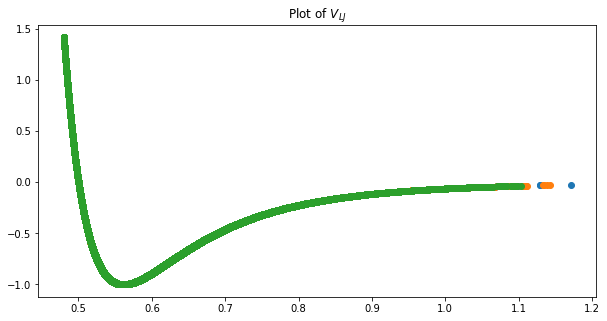

Max Side= 1.1715916922924245 Min Side= 0.4800010027803724


In [ ]:

# Plotting as a fn of 1 side lenght
plt.figure( figsize=(10,5) )
plt.title('Plot of $V_{LJ}$')
plt.scatter(side_lenghts[:,0], LJ(side_lenghts[:,0],sigma,sigma) )
plt.scatter(side_lenghts[:,1], LJ(side_lenghts[:,1],sigma,sigma) )
plt.scatter(side_lenghts[:,2], LJ(side_lenghts[:,2],sigma,sigma) )
plt.show()

print('Max Side=',np.max(side_lenghts),'Min Side=', np.min(side_lenghts))

$E = \Sigma_{nearest}(\epsilon_1+\epsilon_2+\epsilon_3) = 2(\epsilon_1+\epsilon_2+\epsilon_3)$

In [ ]:
# Using the encoder to generate latent space points
x_data_lat = encoder.predict(euc_data)
x_data_sid = side_lenghts
y_data     = e

print('Max En = ', np.max(y_data))
print('Min En = ', np.min(y_data))

Max En =  7.293535144637394
Min En =  -5.999181501906909


In [ ]:
df = pd.DataFrame()
df['x1'] = euc_data[:,0];   df['x2'] = euc_data[:,3];   df['x3'] = euc_data[:,6];
df['y1'] = euc_data[:,1];   df['y2'] = euc_data[:,4];   df['y3'] = euc_data[:,7];
df['z1'] = euc_data[:,2];   df['z2'] = euc_data[:,5];   df['z3'] = euc_data[:,8];

df['L1'] = x_data_sid[:,0]; df['L2'] = x_data_sid[:,1]; df['L3'] = x_data_sid[:,2];
df['N1'] = x_data_lat[:,0]; df['N2'] = x_data_lat[:,1]; df['N3'] = x_data_lat[:,2];

df['En'] = e

df

,x1,x2,x3,y1,y2,y3,z1,z2,z3,L1,L2,L3,N1,N2,N3,En
0,0.628361,0.113053,0.168092,0.448826,0.382759,0.100324,0.486600,0.566106,0.139923,0.525574,0.514228,0.673414,0.825791,1.751853,1.756245,-3.697324
1,0.102220,0.504830,0.452334,0.473044,0.181795,0.691696,0.124039,0.506093,0.593603,0.626806,0.520013,0.625203,1.168051,1.511720,1.901192,-4.401848
2,0.579853,0.067120,0.127789,0.654032,0.581513,0.141946,0.290965,0.367753,0.009978,0.523499,0.570003,0.738612,0.806400,2.057202,1.788000,-4.142716
3,0.303176,0.234525,0.684665,0.593172,0.287197,0.274419,0.111343,0.489949,0.039121,0.491606,0.637209,0.502347,1.337389,1.683218,0.963256,-0.700135
4,0.690514,0.293126,0.208840,0.124266,0.592270,0.332597,0.268456,0.693282,0.170672,0.746607,0.589623,0.533829,1.777000,1.273565,1.829457,-4.279766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.532141,0.256361,0.210489,0.215143,0.024867,0.584151,0.589077,0.029121,0.169022,0.652542,0.578339,0.645037,1.309143,1.666004,1.884273,-4.595972
199996,0.416286,0.501847,0.609509,0.513495,0.091340,0.565368,0.055295,0.497530,0.689383,0.617339,0.522591,0.664901,1.072816,1.632729,1.961630,-4.235109
199997,0.143858,0.659405,0.164319,0.084352,0.378294,0.613956,0.012129,0.496634,0.006710,0.766117,0.735305,0.530027,2.130093,1.592543,1.561970,-2.947764
199998,0.108123,0.050411,0.639369,0.662493,0.625632,0.431124,0.091079,0.691980,0.600602,0.604790,0.626940,0.771601,1.049132,2.162946,1.959714,-3.816049


In [ ]:
model  = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model" ,
                                    compile=False)
model.compile( loss = loss_function)
model.evaluate(x = euc_data, y = euc_data)

6250/6250 [==============================] - 7s 1ms/step - loss: 0.0048


0.004772651940584183

In [ ]:
df.to_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/LJ_data.csv')

### Prepping/loading data

In [ ]:
def normalize(x,x_min,x_max):
  return (x-x_min) / (x_max-x_min)

def unnormalize(x,x_min,x_max):
  return x*(x_max-x_min)+x_min

In [ ]:
# Loading data in from dataframe, and parsing
dtf = pd.read_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/LJ_data.csv')

In [ ]:
# Euclidean data
x_data_euc = np.array([dtf['x1'],dtf['y1'],dtf['z1'],
                       dtf['x2'],dtf['y2'],dtf['z2'],
                       dtf['x3'],dtf['y3'],dtf['z3'] ]).T

# Side len data
x_data_sid = np.array([dtf['L1'],
                       dtf['L2'],
                       dtf['L3']]).T

# Latent space data
x_data_lat = np.array([dtf['N1'],
                       dtf['N2'],
                       dtf['N3']]).T
x_min_lat, x_max_lat  = np.min(x_data_lat), np.max(x_data_lat) 
x_data_lat = normalize(x_data_lat,x_min_lat, x_max_lat)

# LJ-energy data
y_data     = np.array([dtf['En']]).T.flatten()
y_min, y_max  = np.min(y_data), np.max(y_data) 
y_data = normalize(y_data,y_min, y_max)

In [ ]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train_euc,  x_val_euc = train_test_split(x_data_euc , test_size = 0.1  , shuffle = False)
x_train_euc, x_test_euc = train_test_split(x_train_euc, test_size = 1./9., shuffle = False)

# Side training x-data
x_train_sid,  x_val_sid = train_test_split( x_data_sid , test_size = 0.1 , shuffle = False)
x_train_sid, x_test_sid = train_test_split(x_train_sid, test_size = 1./9., shuffle = False)

# Latent variables training x-data
x_train_lat, x_val_lat  = train_test_split(x_data_lat , test_size = 0.1  , shuffle = False)
x_train_lat, x_test_lat = train_test_split(x_train_lat, test_size = 1./9., shuffle = False)

# Energy y-data
y_train, y_val          = train_test_split(y_data     , test_size = 0.1  , shuffle = False)
y_train, y_test         = train_test_split(y_train    , test_size = 1./9., shuffle = False)

### Building the models

In [ ]:
def model(inp):
  
  x = Dense( 64, activation = tf.keras.layers.LeakyReLU()    )(inp)
  x = Dense( 32, activation = tf.keras.layers.LeakyReLU()    )(x)
  x = Dense( 16, activation = tf.keras.layers.LeakyReLU()    )(x)
  x = Dense(  1, activation = 'linear'         )(x)

  return Model(inp, x)

In [ ]:
# Inputs
input_euc  = Input(shape=(9,))
input      = Input(shape=(3,))

In [ ]:
# Side model
en_predictor_sid = model(input)
en_predictor_sid.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss='mse')

In [ ]:
# Latent Model 
en_predictor_lat = model(input)
en_predictor_lat.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss='mse')

In [ ]:
# Euclid Model 
en_predictor_euc = model(input_euc)
en_predictor_euc.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss='mse')

### Training

In [ ]:
# Latent model

history_l = en_predictor_lat.fit(x_train_lat, y_train,
                                validation_data=(x_val_lat, y_val),
                                epochs=500)

Epoch 1/500
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0076 - val_loss: 2.7910e-04
Epoch 2/500
5000/5000 [==============================] - 6s 1ms/step - loss: 3.1591e-04 - val_loss: 1.9209e-04
Epoch 3/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.4741e-04 - val_loss: 1.8630e-04
Epoch 4/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.2898e-04 - val_loss: 1.8976e-04
Epoch 5/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0008e-04 - val_loss: 1.5134e-04
Epoch 6/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0773e-04 - val_loss: 2.0734e-04
Epoch 7/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0321e-04 - val_loss: 1.8828e-04
Epoch 8/500
5000/5000 [==============================] - 6s 1ms/step - loss: 1.8012e-04 - val_loss: 1.5869e-04
Epoch 9/500
5000/5000 [==============================] - 6s 1ms/step - loss: 1.8294e-04 - val_loss: 1.5230e-04
Epoch

In [ ]:
en_predictor_lat.evaluate(x_test_lat,y_test)

625/625 [==============================] - 1s 966us/step - loss: 9.5366e-05


9.536580182611942e-05

In [ ]:
en_predictor_lat.save("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Lat")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Lat/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Lat/assets


In [ ]:
# Side model

history_s = en_predictor_sid.fit(x_train_sid, y_train,
                                validation_data=(x_val_sid, y_val),
                                batch_size = 32,
                                epochs=500)

Epoch 1/500
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0097 - val_loss: 5.1381e-04
Epoch 2/500
5000/5000 [==============================] - 6s 1ms/step - loss: 4.4079e-04 - val_loss: 1.6389e-04
Epoch 3/500
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0693e-04 - val_loss: 1.2287e-04
Epoch 4/500
5000/5000 [==============================] - 6s 1ms/step - loss: 1.6423e-04 - val_loss: 7.7823e-05
Epoch 5/500
5000/5000 [==============================] - 6s 1ms/step - loss: 1.2304e-04 - val_loss: 7.8724e-05
Epoch 6/500
5000/5000 [==============================] - 6s 1ms/step - loss: 1.0855e-04 - val_loss: 6.8046e-05
Epoch 7/500
5000/5000 [==============================] - 6s 1ms/step - loss: 9.6909e-05 - val_loss: 7.0677e-05
Epoch 8/500
5000/5000 [==============================] - 6s 1ms/step - loss: 8.9261e-05 - val_loss: 5.6606e-05
Epoch 9/500
5000/5000 [==============================] - 6s 1ms/step - loss: 7.5397e-05 - val_loss: 8.5703e-05
Epoch

In [ ]:
en_predictor_sid.evaluate(x_test_sid,y_test)

625/625 [==============================] - 1s 938us/step - loss: 6.4715e-06


6.471532742580166e-06

In [ ]:
en_predictor_sid.save("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Sid")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Sid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Sid/assets


In [ ]:
# Euc model

history_e = en_predictor_euc.fit(x_train_euc, y_train,
                                validation_data=(x_val_euc, y_val),
                                verbose = 2,
                                epochs = 500)

Epoch 1/500
5000/5000 - 5s - loss: 0.0142 - val_loss: 0.0142
Epoch 2/500
5000/5000 - 5s - loss: 0.0140 - val_loss: 0.0140
Epoch 3/500
5000/5000 - 5s - loss: 0.0139 - val_loss: 0.0140
Epoch 4/500
5000/5000 - 5s - loss: 0.0138 - val_loss: 0.0137
Epoch 5/500
5000/5000 - 5s - loss: 0.0134 - val_loss: 0.0132
Epoch 6/500
5000/5000 - 5s - loss: 0.0129 - val_loss: 0.0126
Epoch 7/500
5000/5000 - 5s - loss: 0.0127 - val_loss: 0.0127
Epoch 8/500
5000/5000 - 5s - loss: 0.0125 - val_loss: 0.0127
Epoch 9/500
5000/5000 - 5s - loss: 0.0123 - val_loss: 0.0124
Epoch 10/500
5000/5000 - 5s - loss: 0.0121 - val_loss: 0.0124
Epoch 11/500
5000/5000 - 6s - loss: 0.0119 - val_loss: 0.0117
Epoch 12/500
5000/5000 - 6s - loss: 0.0115 - val_loss: 0.0108
Epoch 13/500
5000/5000 - 5s - loss: 0.0110 - val_loss: 0.0104
Epoch 14/500
5000/5000 - 5s - loss: 0.0106 - val_loss: 0.0115
Epoch 15/500
5000/5000 - 5s - loss: 0.0105 - val_loss: 0.0101
Epoch 16/500
5000/5000 - 5s - loss: 0.0103 - val_loss: 0.0097
Epoch 17/500
5000

KeyboardInterrupt: ignored

In [ ]:
# Euc model

history_e = en_predictor_euc.fit(x_train_euc, y_train,
                                validation_data=(x_val_euc, y_val),
                                verbose = 2,
                                epochs = 500)

Epoch 1/500
5000/5000 - 5s - loss: 0.0141 - val_loss: 0.0143
Epoch 2/500
5000/5000 - 4s - loss: 0.0139 - val_loss: 0.0138
Epoch 3/500
5000/5000 - 5s - loss: 0.0137 - val_loss: 0.0136
Epoch 4/500
5000/5000 - 5s - loss: 0.0135 - val_loss: 0.0133
Epoch 5/500
5000/5000 - 4s - loss: 0.0131 - val_loss: 0.0128
Epoch 6/500
5000/5000 - 4s - loss: 0.0126 - val_loss: 0.0123
Epoch 7/500
5000/5000 - 5s - loss: 0.0119 - val_loss: 0.0118
Epoch 8/500
5000/5000 - 5s - loss: 0.0113 - val_loss: 0.0112
Epoch 9/500
5000/5000 - 4s - loss: 0.0103 - val_loss: 0.0095
Epoch 10/500
5000/5000 - 5s - loss: 0.0089 - val_loss: 0.0099
Epoch 11/500
5000/5000 - 5s - loss: 0.0079 - val_loss: 0.0079
Epoch 12/500
5000/5000 - 5s - loss: 0.0074 - val_loss: 0.0068
Epoch 13/500
5000/5000 - 4s - loss: 0.0071 - val_loss: 0.0084
Epoch 14/500
5000/5000 - 4s - loss: 0.0068 - val_loss: 0.0064
Epoch 15/500
5000/5000 - 4s - loss: 0.0067 - val_loss: 0.0060
Epoch 16/500
5000/5000 - 4s - loss: 0.0064 - val_loss: 0.0064
Epoch 17/500
5000

In [ ]:
en_predictor_euc.evaluate(x_test_euc,y_test)

625/625 [==============================] - 1s 874us/step - loss: 4.6007e-04


0.00046006569755263627

In [ ]:
en_predictor_euc.save("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Euc")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Euc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/En_Pred_Euc/assets


### Evaluation

In [ ]:
def inv_norm(x,x_min,x_max):
  return (x_max-x_min)*x+x_min

In [ ]:
preds = en_predictor_euc.predict(x = x_test_euc)

print( (inv_norm(preds, y_min, y_max)- inv_norm(y_test, y_min, y_max)).mean() )

0.012000779857787804


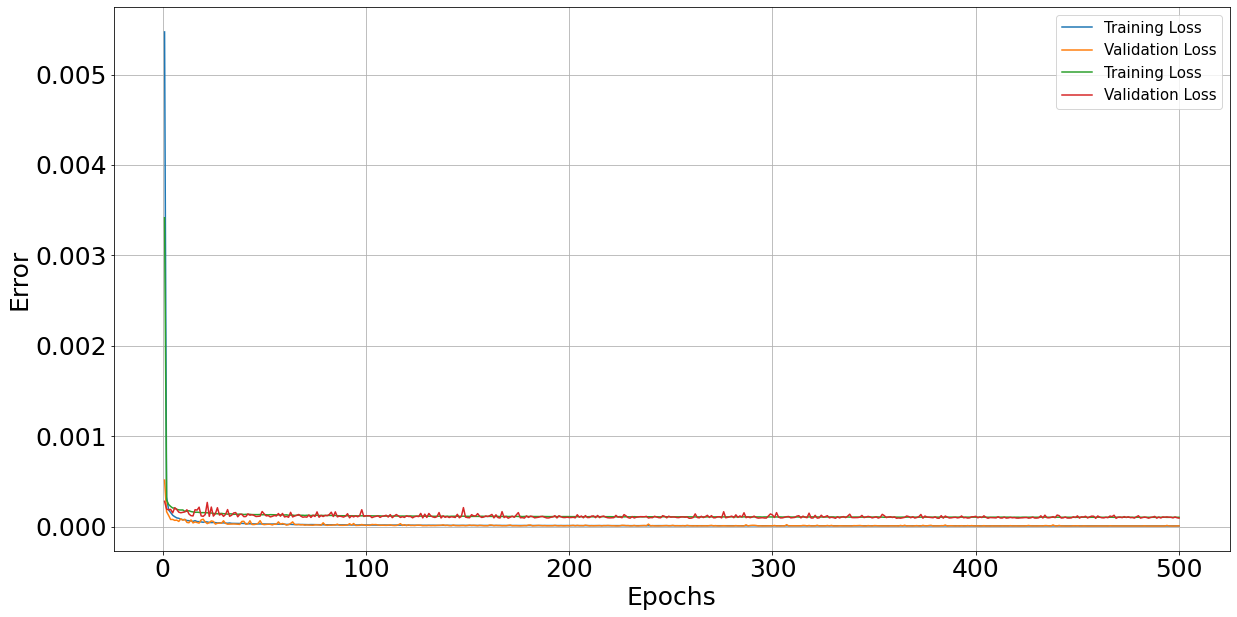

In [ ]:
# Plot Training Loss and Validation Loss

plt.figure(figsize=(20,10))
plt.plot(range(1, len(history_s.history['loss'    ])+1,1), history_s.history['loss'    ], c=r,label='Sides Training Loss'  ) 
plt.plot(range(1, len(history_s.history['val_loss'])+1,1), history_s.history['val_loss'], c=r,label='Sides Validation Loss')
plt.plot(range(1, len(history_l.history['loss'    ])+1,1), history_l.history['loss'    ], c=b,label='Latent Training Loss'  ) 
plt.plot(range(1, len(history_l.history['val_loss'])+1,1), history_l.history['val_loss'], c=b,label='Latent Validation Loss')
matplotlib.rc('font', size=15)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid()

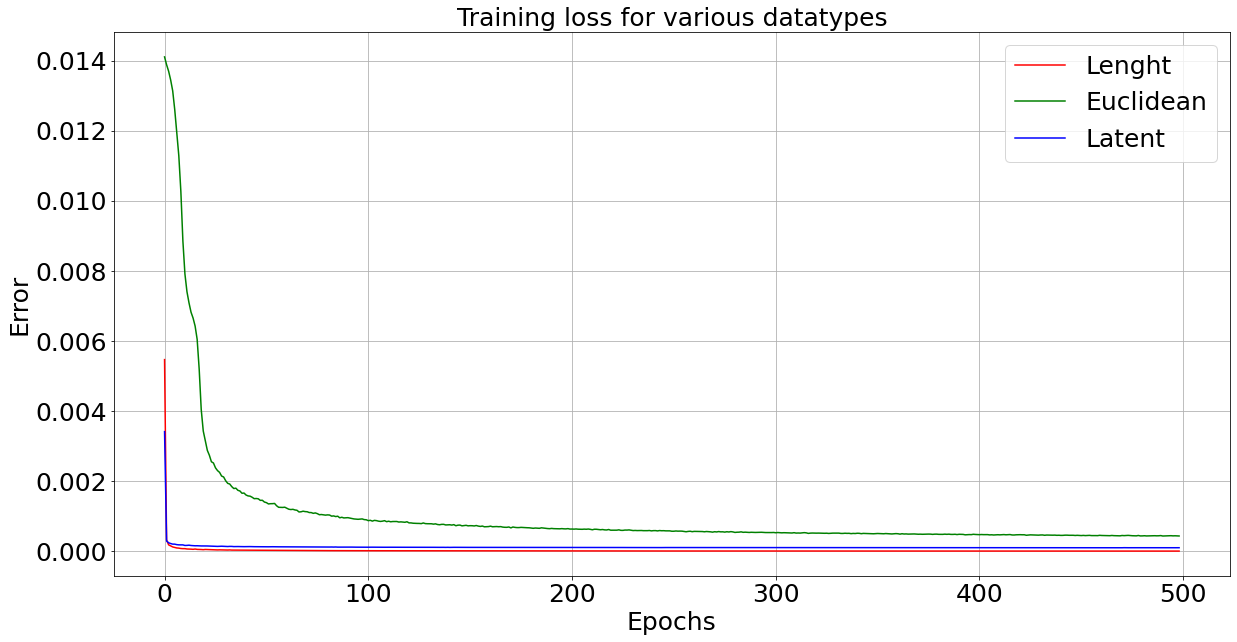

In [ ]:
# Plot Training Loss and Validation Loss
s=1
plt.figure(figsize=(20,10))
plt.title('Training loss for various datatypes', size=25)
plt.plot(range( len(history_s.history['loss']) - s ), history_s.history['loss'][:-s], label='Lenght',   c='r'  ) 
plt.plot(range( len(history_e.history['loss']) - s ), history_e.history['loss'][:-s], label='Euclidean',c='g' )
plt.plot(range( len(history_l.history['loss']) - s ), history_l.history['loss'][:-s], label='Latent',   c='b' ) 
matplotlib.rc('font', size=25)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend() 
plt.grid()

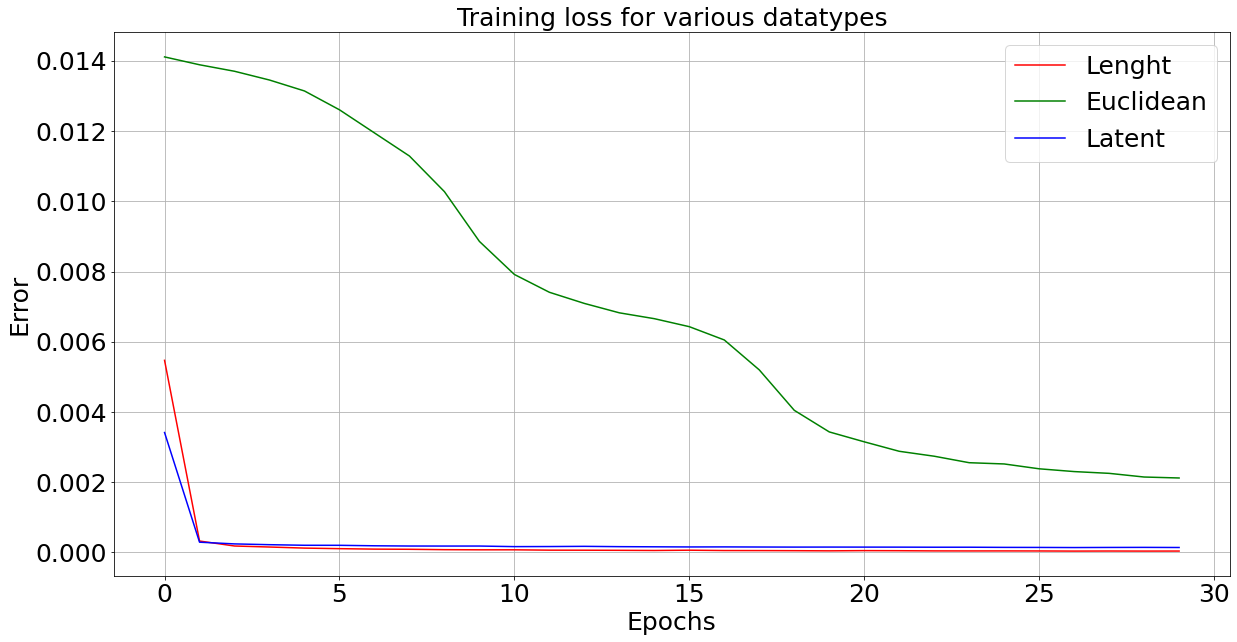

In [ ]:
# Plot Training Loss and Validation Loss
s=470
plt.figure(figsize=(20,10))
plt.title('Training loss for various datatypes', size=25)
plt.plot(range( len(history_s.history['loss']) - s ), history_s.history['loss'][:-s], label='Lenght',   c='r'  ) 
plt.plot(range( len(history_e.history['loss']) - s ), history_e.history['loss'][:-s], label='Euclidean',c='g' )
plt.plot(range( len(history_l.history['loss']) - s ), history_l.history['loss'][:-s], label='Latent',   c='b' ) 
matplotlib.rc('font', size=25)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend() 
plt.grid()